In [2]:
# ---------------------------------------------------------------------------
# Cell 1: Setup Awal & Instalasi Library (JALANKAN SEKALI, LALU WAJIB RESTART RUNTIME)
# ---------------------------------------------------------------------------
!pip uninstall urllib3 -y
!pip uninstall requests -y
!pip uninstall pytrends -y
print("Uninstall library lama (jika ada) selesai.")

!pip install urllib3==1.26.18 -q
!pip install requests==2.28.2 -q
!pip install pytrends==4.9.2 -q
!pip install circlify matplotlib pandas numpy openpyxl -q

print("="*60)
print("PERINTAH INSTALASI SELESAI.")
print("!! PENTING !! SEKARANG, RESTART RUNTIME COLAB ANDA !!")
print("Menu 'Runtime' -> 'Restart session' (atau 'Restart runtime').")
print("Setelah restart, baru jalankan sel-sel berikutnya.")
print("="*60)

Found existing installation: urllib3 2.4.0
Uninstalling urllib3-2.4.0:
  Successfully uninstalled urllib3-2.4.0
Found existing installation: requests 2.32.3
Uninstalling requests-2.32.3:
  Successfully uninstalled requests-2.32.3
Uninstall library lama (jika ada) selesai.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 12.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.11.0 requires requests, which is not installed.
kaggle 1.7.4.5 requires requests, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 r

In [12]:
# LANGKAH 0B: IMPORT LIBRARY
import pandas as pd
from pytrends.request import TrendReq
from pytrends.exceptions import TooManyRequestsError
import time
import matplotlib.pyplot as plt
import circlify
import numpy as np
import calendar
import os

print("Library berhasil di-import.")

# LANGKAH 1: MOUNT GOOGLE DRIVE & KONFIGURASI PATH
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    DRIVE_BASE_PATH = '/content/drive/My Drive/Colab Data JKT48/'
    print("Google Drive berhasil di-mount.")
    if not os.path.exists(DRIVE_BASE_PATH):
        os.makedirs(DRIVE_BASE_PATH)
        print(f"Folder '{DRIVE_BASE_PATH}' telah dibuat.")
except ModuleNotFoundError:
    DRIVE_BASE_PATH = './'
    print("Tidak dalam lingkungan Colab.")
except Exception as e:
    print(f"Error saat mounting Drive: {e}")
    DRIVE_BASE_PATH = './'

if DRIVE_BASE_PATH == './' and not os.path.exists(DRIVE_BASE_PATH):
    os.makedirs(DRIVE_BASE_PATH)

FILENAME_CSV_INPUT = os.path.join(DRIVE_BASE_PATH, 'jkt48_members_data.csv')

# --- PERUBAHAN DI SINI: TENTUKAN RANGE ID DAN TAHUN ANALISIS ---
member_id_start = 277
member_id_end = 293
analysis_start_date = "2023-11-18"
analysis_end_date = "2025-05-31"

BENCHMARK_KEYWORD = "Freya JKT48" # Pastikan ini terdefinisi
benchmark_file_suffix = BENCHMARK_KEYWORD.replace(" ", "_").replace("JKT48","").strip('_') if BENCHMARK_KEYWORD else "DefaultBenchmark"

# Definisikan FILENAME_CSV_RECAP_OUTPUT dengan nama yang mencerminkan rentang ID dan tanggal
FILENAME_CSV_RECAP_OUTPUT = os.path.join(DRIVE_BASE_PATH, f"jkt48_trends_REKAP_ID_{member_id_start}-{member_id_end}_{benchmark_file_suffix}_RAW_{analysis_start_date}_to_{analysis_end_date}.csv")
BUBBLE_CHART_OUTPUT_PATH = DRIVE_BASE_PATH

print(f"Path dasar untuk output: {DRIVE_BASE_PATH}")
print(f"File input member: {FILENAME_CSV_INPUT}")
print(f"File output ringkasan rekap: {FILENAME_CSV_RECAP_OUTPUT}")

Library berhasil di-import.
Mounted at /content/drive
Google Drive berhasil di-mount.
Path dasar untuk output: /content/drive/My Drive/Colab Data JKT48/
File input member: /content/drive/My Drive/Colab Data JKT48/jkt48_members_data.csv
File output ringkasan rekap: /content/drive/My Drive/Colab Data JKT48/jkt48_trends_REKAP_ID_277-293_Freya_RAW_2023-11-18_to_2025-05-31.csv


In [13]:
# LANGKAH 2: MUAT DATA MEMBER DARI FILE CSV DAN FILTER BERDASARKAN ID
list_member_keywords_to_analyze = []
df_members_loaded = None

try:
    if not os.path.exists(FILENAME_CSV_INPUT):
        print(f"Peringatan: File CSV input member TIDAK DITEMUKAN di {FILENAME_CSV_INPUT}.")
    else:
        df_members_loaded = pd.read_csv(FILENAME_CSV_INPUT)
        # --- PERBAIKAN DI SINI: Gunakan 'ID Member' ---
        if 'Nama Panggilan JKT48' in df_members_loaded.columns and 'ID Member' in df_members_loaded.columns:
            # Filter berdasarkan ID Member
            df_filtered_members = df_members_loaded[
                (df_members_loaded['ID Member'] >= member_id_start) & # Kolom 'ID Member'
                (df_members_loaded['ID Member'] <= member_id_end)     # Kolom 'ID Member'
            ]
            list_member_keywords_to_analyze = df_filtered_members['Nama Panggilan JKT48'].dropna().astype(str).unique().tolist()
            print(f"Berhasil memuat {len(list_member_keywords_to_analyze)} nama member unik dari CSV (ID Member {member_id_start}-{member_id_end}).")
            if not list_member_keywords_to_analyze:
                print("Peringatan: Daftar member kosong setelah filter ID.")
        else:
            print(f"Error: Kolom 'Nama Panggilan JKT48' atau 'ID Member' tidak ditemukan di file {FILENAME_CSV_INPUT}.") # Pesan error diperbarui

except FileNotFoundError:
    print(f"File CSV input tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error saat memuat atau memproses CSV member: {e}")

if not list_member_keywords_to_analyze:
    print("Menggunakan daftar member contoh karena gagal memuat dari CSV atau daftar kosong.")
    list_member_keywords_to_analyze = [
        "Freya JKT48", "Zee JKT48", "Christy JKT48", "Marsha JKT48", "Gita JKT48",
        "Feni JKT48", "Gracia JKT48", "Muthe JKT48"
    ]
    print(f"Daftar member contoh yang digunakan ({len(list_member_keywords_to_analyze)}).")

Berhasil memuat 15 nama member unik dari CSV (ID Member 277-293).


In [14]:
# LANGKAH 3: INISIALISASI PYTRENDS DAN KONFIGURASI ANALISIS LANJUTAN
try:
    pytrends = TrendReq(hl='id-ID', tz=-420, timeout=(20,60), retries=3, backoff_factor=0.2)
    print("Objek TrendReq berhasil diinisialisasi.")
except Exception as e:
    print(f"Gagal menginisialisasi TrendReq: {e}")
    pytrends = None

geo = 'ID'

if BENCHMARK_KEYWORD in list_member_keywords_to_analyze:
    list_member_keywords_to_analyze.remove(BENCHMARK_KEYWORD)
    print(f"Kata kunci '{BENCHMARK_KEYWORD}' dihapus dari daftar member yang dianalisis karena digunakan sebagai benchmark.")

recap_display_name = f'Rekap {analysis_start_date} hingga {analysis_end_date} (vs {BENCHMARK_KEYWORD})'
recap_start_date = analysis_start_date
recap_end_date = analysis_end_date
recap_pytrends_format = f"{recap_start_date} {recap_end_date}"

gprop_configs = {
    'Google Search (Web)': '',
    'Youtube': 'youtube'
}

# --- PENYESUAIAN JEDA WAKTU & RETRY ---
DELAY_PER_BATCH_REQUEST = 10    # DETIK! Lebih cepat, tapi pantau Error 429. Jika sering, NAIKKAN (misal 15, 20, 30).
MAX_RETRIES_ON_429 = 2          # Jumlah percobaan ulang spesifik jika kena error 429 (total 3 attempt).
DELAY_AFTER_RATE_LIMIT_ERROR = 120 # 2 MENIT! Jeda tetap antar retry 429 (tidak eksponensial lagi). NAIKKAN jika 2 menit kurang.

DELAY_PER_GPROP_ANALYSIS = 20 # Jeda antar Web dan YouTube untuk rekap

all_recap_scores_data = []

print("Konfigurasi analisis umum siap.")
print(f"Benchmark yang akan digunakan: '{BENCHMARK_KEYWORD}'")
print(f"Jumlah member yang akan dianalisis (tidak termasuk benchmark): {len(list_member_keywords_to_analyze)}")
print(f"Periode Analisis: {recap_display_name} ({recap_pytrends_format})")
print(f"Jeda per batch: {DELAY_PER_BATCH_REQUEST} detik")
print(f"Max Retries jika Error 429: {MAX_RETRIES_ON_429}")
print(f"Jeda antar Retry Error 429: {DELAY_AFTER_RATE_LIMIT_ERROR} detik")


Objek TrendReq berhasil diinisialisasi.
Konfigurasi analisis umum siap.
Benchmark yang akan digunakan: 'Freya JKT48'
Jumlah member yang akan dianalisis (tidak termasuk benchmark): 15
Periode Analisis: Rekap 2023-11-18 hingga 2025-05-31 (vs Freya JKT48) (2023-11-18 2025-05-31)
Jeda per batch: 10 detik
Max Retries jika Error 429: 2
Jeda antar Retry Error 429: 120 detik


In [16]:
# LANGKAH 4: ANALISIS PERIODE REKAP DENGAN BENCHMARK "JKT48" (RETRY DITINGKATKAN)
batch_size_members = 4

# Pastikan variabel dari Cell 3 sudah ada dan valid
if 'pytrends' not in globals() or pytrends is None:
    print("\nERROR: Objek TrendReq (pytrends) tidak terinisialisasi. Jalankan Cell 3 terlebih dahulu.")
elif 'list_member_keywords_to_analyze' not in globals() or not list_member_keywords_to_analyze:
    print("\nERROR: Daftar member ('list_member_keywords_to_analyze') kosong. Jalankan Cell 3 dan pastikan CSV termuat.")
else:
    if 'all_recap_scores_data' not in globals(): # Fallback jika sel dijalankan terpisah
        all_recap_scores_data = []
        print("Warning: 'all_recap_scores_data' diinisialisasi ulang di Cell 4.")

    # Ambil konfigurasi dari Cell 3 (atau set default jika tidak ada)
    MAX_MANUAL_RETRIES = globals().get('MAX_RETRIES_ON_429', 2) # Gunakan ini untuk semua jenis error API yang mau di-retry
    DELAY_IF_429_ERROR = globals().get('DELAY_AFTER_RATE_LIMIT_ERROR_BASE', 180) # Jeda panjang untuk 429
    DELAY_IF_GENERAL_API_ERROR = 60 # Jeda lebih pendek untuk error API umum lainnya (misal 60 detik)

    for gprop_name, gprop_value in gprop_configs.items():
        print(f"\n\n======================================================================")
        print(f"MEMULAI ANALISIS REKAP (1 BENCHMARK '{BENCHMARK_KEYWORD}' + MAKS 4 MEMBER)")
        print(f"UNTUK JENIS TREN: {gprop_name}")
        print(f"PERIODE: {recap_display_name} ({recap_pytrends_format})")
        print(f"======================================================================")

        current_recap_scores_this_gprop = {}

        for i in range(0, len(list_member_keywords_to_analyze), batch_size_members):
            member_batch = list_member_keywords_to_analyze[i:i + batch_size_members]
            member_batch_filtered = [m for m in member_batch if m != BENCHMARK_KEYWORD]
            if not member_batch_filtered: continue

            keywords_for_pytrends = [BENCHMARK_KEYWORD] + member_batch_filtered
            print(f"    Menganalisis kelompok: {keywords_for_pytrends}...")

            batch_processed_successfully = False
            for attempt in range(MAX_MANUAL_RETRIES + 1):
                try:
                    pytrends.build_payload(keywords_for_pytrends, cat=0, timeframe=recap_pytrends_format, geo=geo, gprop=gprop_value)
                    interest_df = pytrends.interest_over_time()

                    print(f"      Jeda {DELAY_PER_BATCH_REQUEST} detik setelah request...") # Jeda normal setelah request berhasil
                    time.sleep(DELAY_PER_BATCH_REQUEST)

                    if not interest_df.empty:
                        if 'isPartial' in interest_df.columns:
                            interest_df = interest_df.drop(columns=['isPartial'])

                        for member_keyword_in_batch in member_batch_filtered:
                            if member_keyword_in_batch in interest_df.columns and not interest_df[member_keyword_in_batch].empty:
                                mean_score_float = interest_df[member_keyword_in_batch].mean()
                                current_recap_scores_this_gprop[member_keyword_in_batch] = mean_score_float if pd.notna(mean_score_float) else 0.0
                                print(f"      - Skor '{member_keyword_in_batch}' (vs grup BM): {mean_score_float:.10f}")
                            else:
                                current_recap_scores_this_gprop[member_keyword_in_batch] = 0.0
                                print(f"      - Data '{member_keyword_in_batch}' (vs grup BM) kosong/tidak ada.")
                    else:
                        for member_keyword_in_batch in member_batch_filtered:
                            current_recap_scores_this_gprop[member_keyword_in_batch] = 0.0
                        print(f"      - Tidak ada data tren yang diterima untuk kelompok {keywords_for_pytrends}.")

                    batch_processed_successfully = True # Tandai batch ini berhasil diproses
                    break  # Sukses, keluar dari loop retry untuk batch ini

                except TooManyRequestsError: # Error 429 spesifik dari pytrends.exceptions
                    print(f"      PERINGATAN (Specific 429): Terkena Error 429 untuk {keywords_for_pytrends}. Percobaan ke-{attempt + 1}/{MAX_MANUAL_RETRIES +1}.")
                    if attempt < MAX_MANUAL_RETRIES:
                        print(f"      Akan mencoba lagi setelah {DELAY_IF_429_ERROR} detik...")
                        time.sleep(DELAY_IF_429_ERROR)
                    else:
                        print(f"      GAGAL TOTAL (Specific 429) setelah {MAX_MANUAL_RETRIES + 1} percobaan untuk {keywords_for_pytrends}.")
                except Exception as e_general: # Menangkap error umum lainnya (termasuk yang membungkus 429 dari 'requests')
                    error_message_lower = str(e_general).lower()
                    is_effectively_429 = "429" in error_message_lower or "too many requests" in error_message_lower

                    print(f"      ERROR (Umum{' - terdeteksi sebagai 429' if is_effectively_429 else ''}): {e_general}. Percobaan ke-{attempt + 1}/{MAX_MANUAL_RETRIES+1}.")

                    if attempt < MAX_MANUAL_RETRIES:
                        current_wait_time = DELAY_IF_429_ERROR if is_effectively_429 else DELAY_IF_GENERAL_API_ERROR
                        print(f"      Akan mencoba lagi setelah {current_wait_time} detik...")
                        time.sleep(current_wait_time)
                    else:
                        print(f"      GAGAL TOTAL (Error Umum) setelah {MAX_MANUAL_RETRIES + 1} percobaan untuk {keywords_for_pytrends}.")

            # Jika setelah semua retry batch tetap tidak berhasil diproses, beri skor 0
            if not batch_processed_successfully:
                print(f"      Memberikan skor 0 untuk semua member di batch {keywords_for_pytrends} karena kegagalan persisten.")
                for member_keyword_in_batch_err in member_batch_filtered:
                    current_recap_scores_this_gprop[member_keyword_in_batch_err] = 0.0

        # Setelah semua batch untuk gprop ini selesai:
        for member, score_val in current_recap_scores_this_gprop.items():
            all_recap_scores_data.append({
                'gprop': gprop_name, 'member': member, 'score_vs_benchmark_group': score_val
            })

        if current_recap_scores_this_gprop:
            scores_to_sort_recap = {m:s for m,s in current_recap_scores_this_gprop.items() if m != BENCHMARK_KEYWORD}
            if scores_to_sort_recap:
                sorted_members_recap = sorted(scores_to_sort_recap.items(), key=lambda item: item[1], reverse=True)
                print(f"\n   --- Hasil Analisis Statis REKAP (Skor vs Grup Benchmark '{BENCHMARK_KEYWORD}') ({recap_display_name}, {gprop_name}) ---")
                # --- PERBAIKAN DI SINI: Tampilkan langsung TOP N ---
                print(f"   TOP {len(sorted_members_recap)} MEMBERS (Ranked):") # Changed to show all available members if < 15
                for rank, (member, score) in enumerate(sorted_members_recap[:15]): # Limiting to 15 ranks
                    print(f"   {rank+1}. {member}: {score:.10f}")
            else: print(f"   Tidak ada skor member (selain benchmark) untuk ditampilkan pada {gprop_name} periode rekap.")
        else: print(f"   Tidak ada skor yang berhasil dikumpulkan untuk {gprop_name} periode rekap.")


        if gprop_name != list(gprop_configs.keys())[-1]:
              print(f"\n\n   Jeda {DELAY_PER_GPROP_ANALYSIS} detik sebelum jenis tren berikutnya untuk rekap...")
              time.sleep(DELAY_PER_GPROP_ANALYSIS)

    # Simpan semua hasil rekap (dari semua gprop) ke CSV setelah loop gprop selesai
    if all_recap_scores_data:
        df_recap_summary_final = pd.DataFrame(all_recap_scores_data)
        try:
            df_recap_summary_final.to_csv(FILENAME_CSV_RECAP_OUTPUT, index=False, encoding='utf-8', float_format='%.10f')
            print(f"\n\nRingkasan lengkap hasil analisis REKAP (vs Grup Benchmark '{BENCHMARK_KEYWORD}') disimpan ke: {FILENAME_CSV_RECAP_OUTPUT}")
        except Exception as e_csv:
            print(f"\n\nGagal menyimpan ringkasan hasil analisis REKAP ke CSV: {e_csv}")
    else:
        print("\n\nTidak ada ringkasan hasil rekap untuk disimpan (all_recap_scores_data kosong).")

    print(f"\nAnalisis Rekap {analysis_start_date} hingga {analysis_end_date} (vs Grup Benchmark '{BENCHMARK_KEYWORD}') selesai untuk semua jenis tren.")



MEMULAI ANALISIS REKAP (1 BENCHMARK 'Freya JKT48' + MAKS 4 MEMBER)
UNTUK JENIS TREN: Google Search (Web)
PERIODE: Rekap 2023-11-18 hingga 2025-05-31 (vs Freya JKT48) (2023-11-18 2025-05-31)
    Menganalisis kelompok: ['Freya JKT48', 'Aralie JKT48', 'Delynn JKT48', 'Lana JKT48', 'Erine JKT48']...
      Jeda 10 detik setelah request...
      - Skor 'Aralie JKT48' (vs grup BM): 0.0246913580
      - Skor 'Delynn JKT48' (vs grup BM): 0.3333333333
      - Skor 'Lana JKT48' (vs grup BM): 0.2098765432
      - Skor 'Erine JKT48' (vs grup BM): 1.4074074074
    Menganalisis kelompok: ['Freya JKT48', 'Fritzy JKT48', 'Lily JKT48', 'Trisha JKT48', 'Levi JKT48']...
      Jeda 10 detik setelah request...
      - Skor 'Fritzy JKT48' (vs grup BM): 2.0493827160
      - Skor 'Lily JKT48' (vs grup BM): 0.7407407407
      - Skor 'Trisha JKT48' (vs grup BM): 2.7407407407
      - Skor 'Levi JKT48' (vs grup BM): 0.0246913580
    Menganalisis kelompok: ['Freya JKT48', 'Nayla JKT48', 'Nachia JKT48', 'Oline JKT

Berhasil memuat data rekap dari: /content/drive/My Drive/Colab Data JKT48/jkt48_trends_REKAP_ID_277-293_Freya_RAW_2023-11-18_to_2025-05-31.csv


Membuat Bubble Chart untuk Jenis Tren: Google Search (Web) (Periode Rekap 2023-11-18 hingga 2025-05-31)
unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


<ipython-input-18-2082958947>:126: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Circle((x, y), r, alpha=0.8, color=member_data_viz.get('color', 'lightgrey'), edgecolor='black', linewidth=0.2))


Bubble chart disimpan ke: /content/drive/My Drive/Colab Data JKT48/jkt48_bubble_ID_277-293_Freya_google_search_(web)_2023-11-18_to_2025-05-31.png


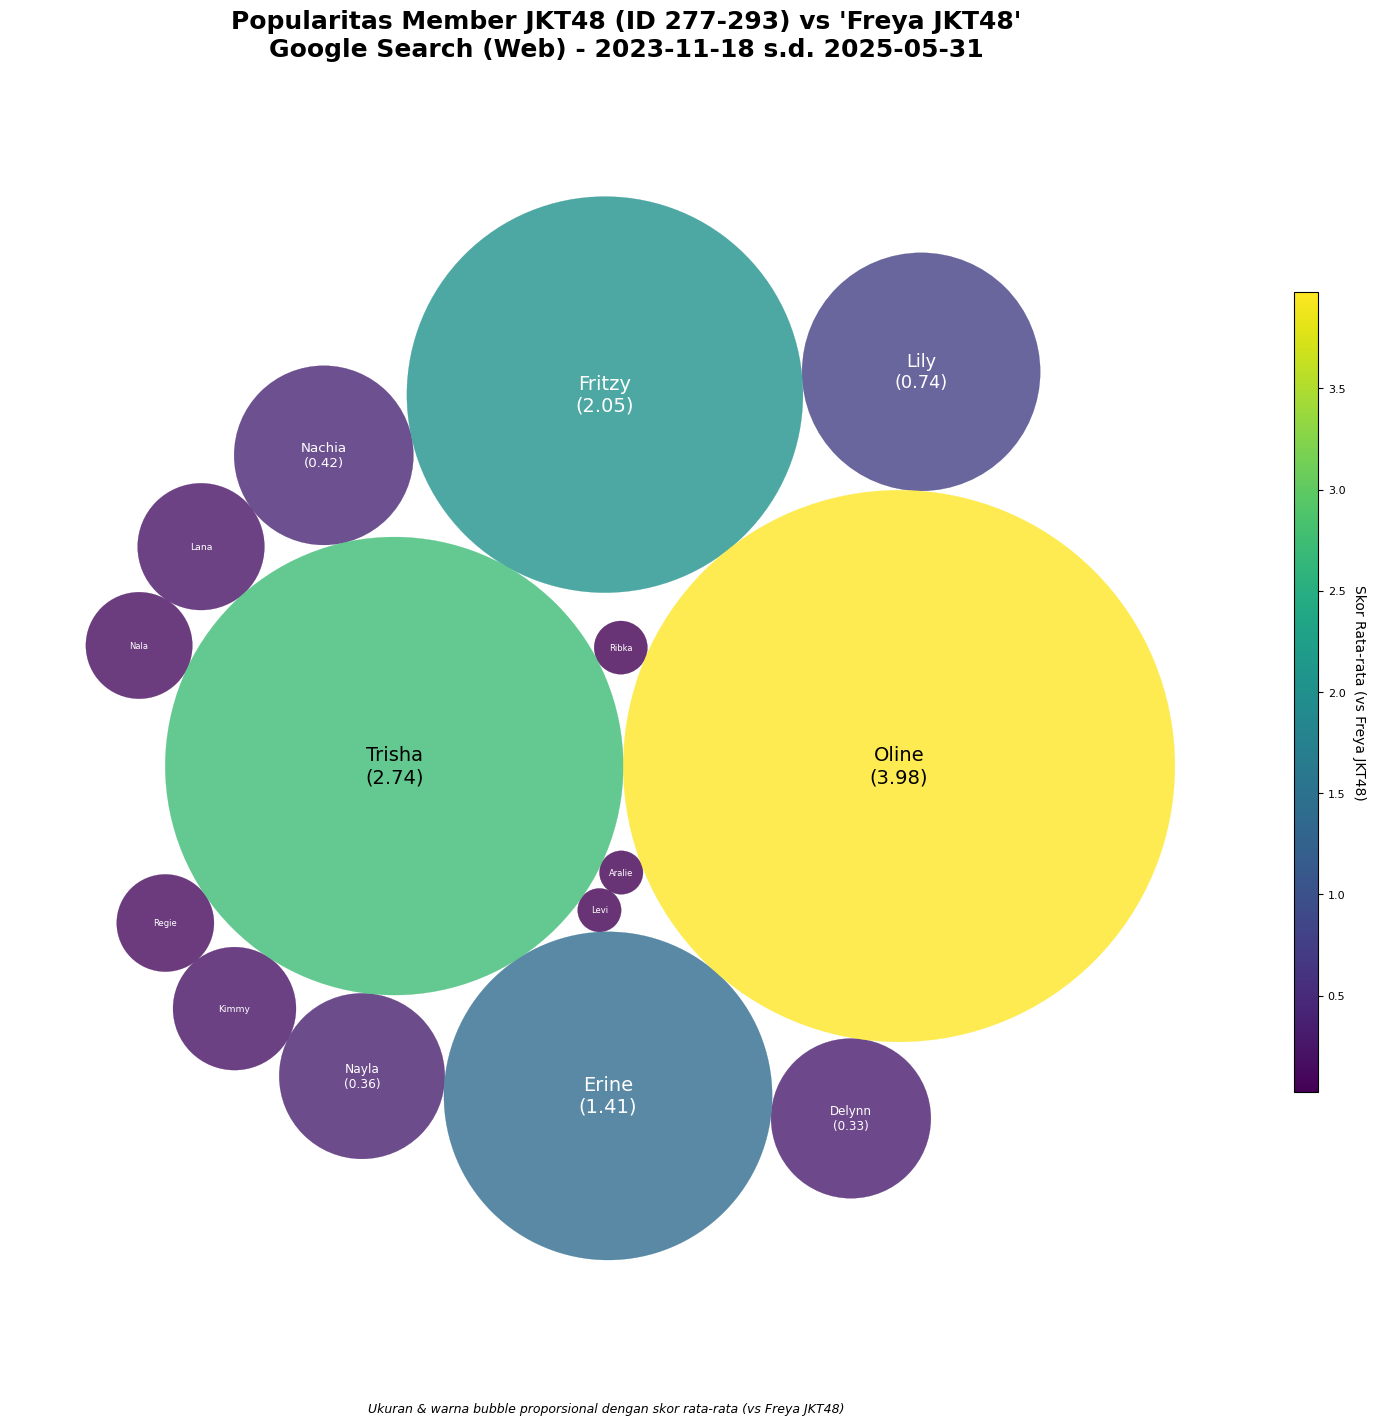



Membuat Bubble Chart untuk Jenis Tren: Youtube (Periode Rekap 2023-11-18 hingga 2025-05-31)
unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


unexpected key 'color' in input is ignored


<ipython-input-18-2082958947>:126: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Circle((x, y), r, alpha=0.8, color=member_data_viz.get('color', 'lightgrey'), edgecolor='black', linewidth=0.2))


Bubble chart disimpan ke: /content/drive/My Drive/Colab Data JKT48/jkt48_bubble_ID_277-293_Freya_youtube_2023-11-18_to_2025-05-31.png


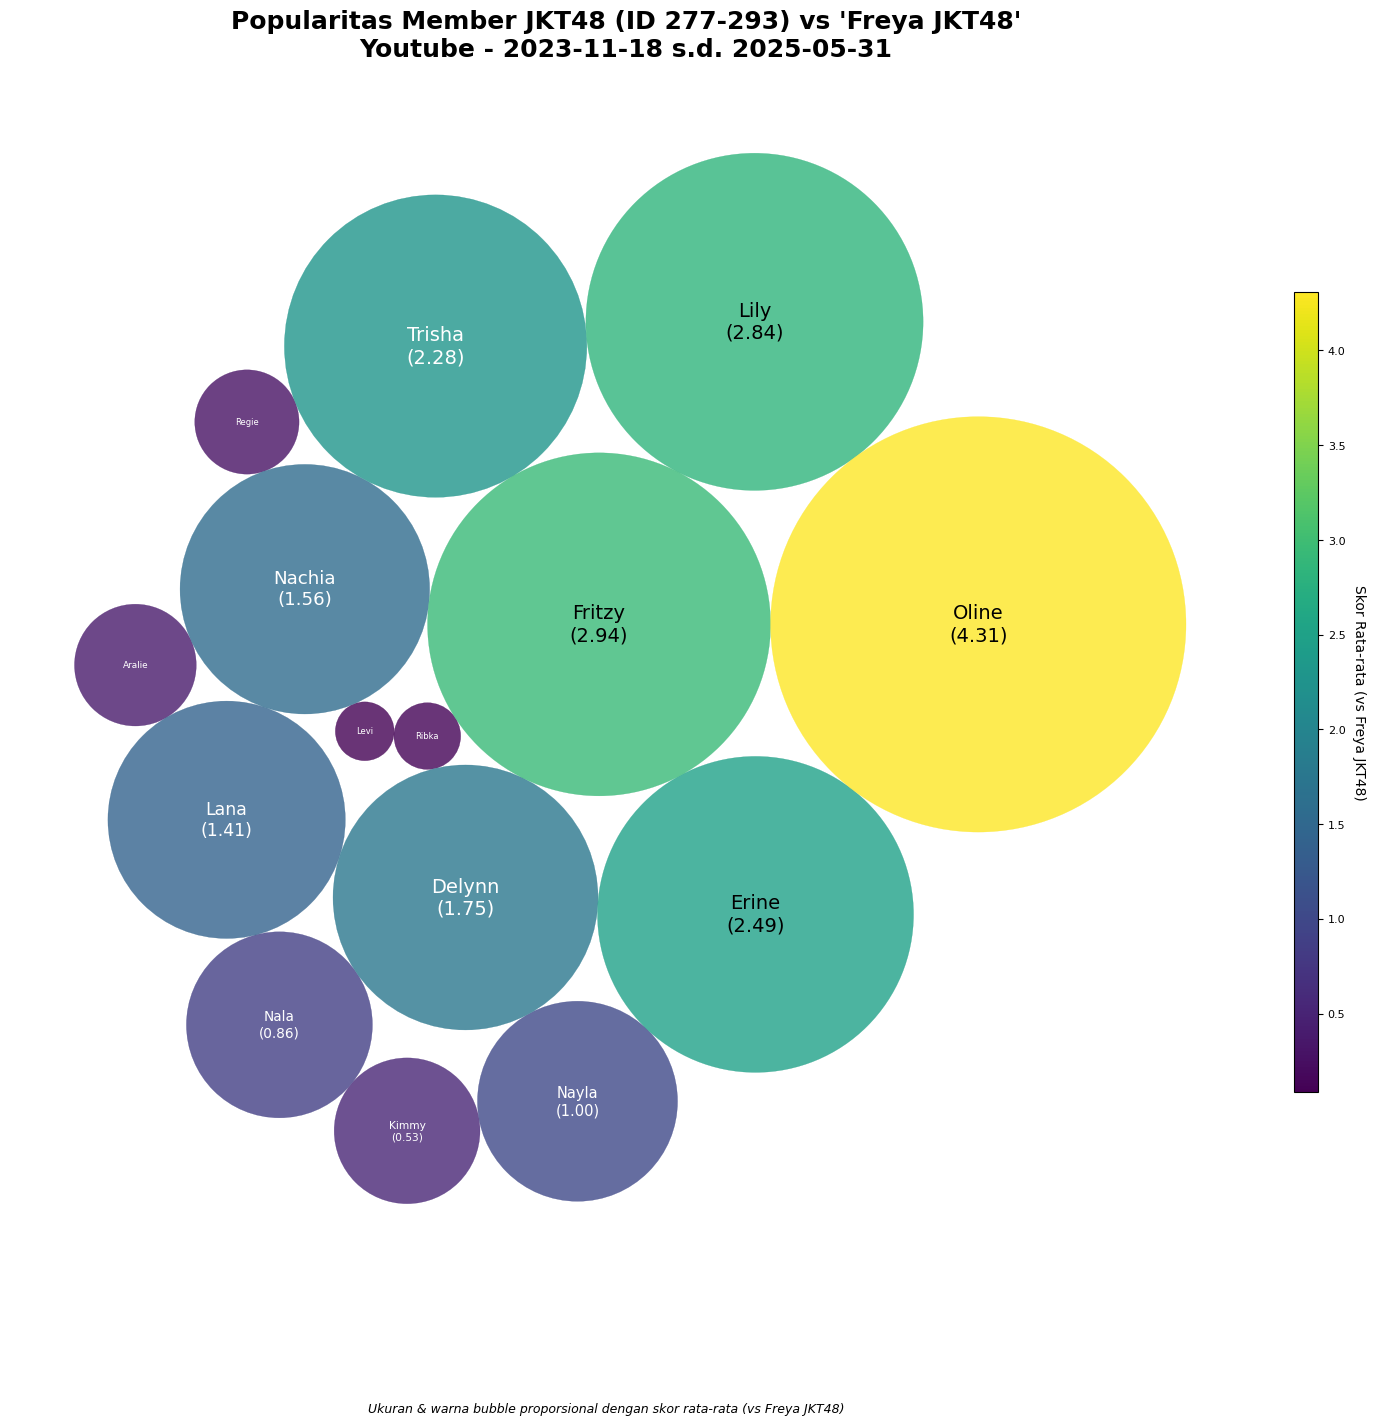


Proses pembuatan Bubble Chart selesai (jika ada data).


In [18]:
# LANGKAH 5: VISUALISASI BUBBLE CHART (BACA DATA DARI FILE CSV HASIL CELL 4)

# Pastikan variabel FILENAME_CSV_RECAP_OUTPUT dan lainnya dari Cell 2 & 3 sudah ada
if 'FILENAME_CSV_RECAP_OUTPUT' not in globals() or \
   'BENCHMARK_KEYWORD' not in globals() or \
   'analysis_start_date' not in globals() or \
   'analysis_end_date' not in globals() or \
   'BUBBLE_CHART_OUTPUT_PATH' not in globals():
    print("ERROR: Variabel konfigurasi (seperti FILENAME_CSV_RECAP_OUTPUT, BENCHMARK_KEYWORD, dll.) tidak terdefinisi.")
    print("Pastikan Cell 2 dan Cell 3 sudah dijalankan dengan sukses di sesi ini.")
else:
    try:
        # Baca data dari file CSV yang disimpan oleh Cell 4
        df_all_recap_scores_for_viz = pd.read_csv(FILENAME_CSV_RECAP_OUTPUT)
        print(f"Berhasil memuat data rekap dari: {FILENAME_CSV_RECAP_OUTPUT}")
        if df_all_recap_scores_for_viz.empty:
            print("Peringatan: File CSV rekap kosong.")
    except FileNotFoundError:
        print(f"ERROR: File CSV rekap tidak ditemukan di {FILENAME_CSV_RECAP_OUTPUT}.")
        print("Pastikan Cell 4 sudah berhasil dijalankan dan menyimpan file tersebut.")
        df_all_recap_scores_for_viz = pd.DataFrame() # Buat dataframe kosong agar tidak error di bawah
    except Exception as e_read_csv:
        print(f"Error saat membaca file CSV rekap: {e_read_csv}")
        df_all_recap_scores_for_viz = pd.DataFrame()

    if df_all_recap_scores_for_viz.empty:
        print("\nTidak ada data rekap yang bisa divisualisasikan.")
    else:
        # Pastikan nama kolom skor benar, sesuai dengan yang disimpan di Cell 4
        score_column_name = 'score_vs_benchmark_group'
        if score_column_name not in df_all_recap_scores_for_viz.columns:
            # Fallback jika nama kolom berbeda karena modifikasi sebelumnya
            if 'Skor (vs Benchmark)' in df_all_recap_scores_for_viz.columns:
                 score_column_name = 'Skor (vs Benchmark)'
            elif 'score' in df_all_recap_scores_for_viz.columns: # Jika hanya 'score'
                 score_column_name = 'score'
            else:
                print(f"Error: Kolom skor yang diharapkan ('{score_column_name}' atau alternatif) tidak ditemukan di CSV.")
                # Hentikan eksekusi sel ini jika kolom skor tidak ada
                raise KeyError(f"Kolom skor tidak ditemukan di CSV: {df_all_recap_scores_for_viz.columns}")

        # Extract year from analysis_end_date for chart title
        chart_year = analysis_end_date.split('-')[0]


        for gprop_name_viz in df_all_recap_scores_for_viz['gprop'].unique():
            print(f"\n\nMembuat Bubble Chart untuk Jenis Tren: {gprop_name_viz} (Periode Rekap {analysis_start_date} hingga {analysis_end_date})")

            df_current_gprop_viz = df_all_recap_scores_for_viz[
                df_all_recap_scores_for_viz['gprop'] == gprop_name_viz
            ][['member', score_column_name]].copy()
            df_current_gprop_viz.rename(columns={score_column_name: 'score'}, inplace=True)

            # Filter out benchmark keyword if it accidentally got into visualization data
            df_current_gprop_viz = df_current_gprop_viz[df_current_gprop_viz['member'] != BENCHMARK_KEYWORD]

            # --- KOREKSI KRUSIAL DI SINI: Pastikan hanya ada satu entri per member ---
            # Group by member and take the mean of scores to handle any potential duplicates
            df_current_gprop_viz = df_current_gprop_viz.groupby('member')['score'].mean().reset_index()


            if df_current_gprop_viz.empty or df_current_gprop_viz['score'].map(lambda x: x if pd.notna(x) else 0).sum() < 0.0000001 : # Toleransi lebih kecil
                print(f"Tidak ada data skor yang cukup signifikan (>0) untuk visualisasi {gprop_name_viz}")
                continue

            df_current_gprop_viz['datum_for_bubble'] = df_current_gprop_viz['score'].apply(
                lambda x: x if (pd.notna(x) and x > 0.000001) else 0.000001 # Nilai kecil jika 0 atau sangat kecil
            )

            data_for_circlify_viz = [{'id': row['member'], 'datum': row['datum_for_bubble']}
                                     for index, row in df_current_gprop_viz.iterrows()]

            if not data_for_circlify_viz:
                print(f"Tidak ada data valid untuk circlify pada {gprop_name_viz}")
                continue

            # Pewarnaan berdasarkan skor asli
            scores_for_color_map = np.array(df_current_gprop_viz['score'].fillna(0).tolist())
            min_s_color = scores_for_color_map.min()
            max_s_color = scores_for_color_map.max()

            if abs(max_s_color - min_s_color) < 1e-9: # Jika semua skor hampir sama (atau sama)
                normalized_scores_color = np.ones(len(scores_for_color_map)) * 0.5
            else:
                normalized_scores_color = (scores_for_color_map - min_s_color) / (max_s_color - min_s_color)

            try:
                cmap_visual = plt.colormaps.get_cmap('viridis')
            except AttributeError:
                cmap_visual = plt.cm.get_cmap('viridis')

            member_to_color_map = {}
            for i, member_name_from_df in enumerate(df_current_gprop_viz['member']):
                member_to_color_map[member_name_from_df] = cmap_visual(normalized_scores_color[i])

            for item_circlify in data_for_circlify_viz:
                item_circlify['color'] = member_to_color_map.get(item_circlify['id'], cmap_visual(0.5))

            try:
                circles_viz = circlify.circlify(data_for_circlify_viz, show_enclosure=False, target_enclosure=circlify.Circle(x=0, y=0, r=1))
            except Exception as e_circle:
                print(f"Error saat membuat layout circlify untuk {gprop_name_viz}: {e_circle}"); continue
            if not circles_viz:
                print(f"Gagal membuat data lingkaran (circles_viz kosong) untuk {gprop_name_viz}"); continue

            fig, ax = plt.subplots(figsize=(16, 16), subplot_kw=dict(aspect="equal"))
            ax.axis("off")
            # Hitung lim setelah circles_viz dipastikan ada dan tidak kosong
            if not circles_viz: continue # Seharusnya sudah ditangani di atas
            # Ensure all circles have x, y, r attributes before calculating lim
            valid_circles = [c for c in circles_viz if c is not None and hasattr(c, 'x') and hasattr(c, 'y') and hasattr(c, 'r')]
            if not valid_circles: continue # Skip if no valid circles found after filtering
            lim = max(max(abs(circle.x) + circle.r, abs(circle.y) + circle.r) for circle in valid_circles)
            plt.xlim(-lim*1.1, lim*1.1); plt.ylim(-lim*1.1, lim*1.1)

            # --- PARAMETER FONT YANG BISA DISESUAIKAN ---
            K_FONT_MULTIPLIER = 60
            MIN_FONT_SIZE = 6
            MAX_FONT_SIZE = 14
            R_NO_LABEL_THRESHOLD = 0.02
            R_NAME_ONLY_THRESHOLD = 0.05

            for circle in circles_viz:
                if circle is None: continue
                x, y, r = circle.x, circle.y, circle.r; member_data_viz = circle.ex
                ax.add_patch(plt.Circle((x, y), r, alpha=0.8, color=member_data_viz.get('color', 'lightgrey'), edgecolor='black', linewidth=0.2))
                final_font_size = max(MIN_FONT_SIZE, min(r * K_FONT_MULTIPLIER, MAX_FONT_SIZE))
                label_to_display = ""; short_name_viz = member_data_viz['id'].replace(' JKT48', '').split(' ')[0]

                if r >= R_NO_LABEL_THRESHOLD:
                    original_score_series = df_current_gprop_viz[df_current_gprop_viz['member'] == member_data_viz['id']]['score']
                    original_score_val = original_score_series.iloc[0] if not original_score_series.empty else 0.0
                    score_text_viz = f"({original_score_val:.2f})" if original_score_val > 0.005 else ""

                    # Adjusted logic for labels: show name only for smaller bubbles, name + score for larger
                    if (r < R_NAME_ONLY_THRESHOLD and original_score_val > 0) or (final_font_size < MIN_FONT_SIZE + 1 and original_score_val > 0): # prioritize name for small circles, or very small font
                        label_to_display = short_name_viz
                        if len(short_name_viz) > 7 and final_font_size <= MIN_FONT_SIZE + 1:
                            label_to_display = short_name_viz[:6] + "." # Truncate long names for small fonts
                    elif original_score_val > 0.005: # Only show score if it's significant
                        label_to_display = f"{short_name_viz}\n{score_text_viz}"
                    else: # If score is tiny or zero, just show name if radius allows, otherwise no label
                        if r >= R_NO_LABEL_THRESHOLD: # Still show name if bubble is visible enough
                            label_to_display = short_name_viz
                            if len(short_name_viz) > 7 and final_font_size <= MIN_FONT_SIZE + 1:
                                label_to_display = short_name_viz[:6] + "."

                if label_to_display:
                    bubble_color_rgb = member_data_viz.get('color', (0.5,0.5,0.5))[:3]
                    luminance = 0.299*bubble_color_rgb[0] + 0.587*bubble_color_rgb[1] + 0.114*bubble_color_rgb[2]
                    text_color_viz = 'white' if luminance < 0.45 else 'black'
                    plt.annotate(label_to_display, (x, y), va='center', ha='center', fontsize=final_font_size, color=text_color_viz, fontweight='normal')

            chart_title_str = f"Popularitas Member JKT48 (ID {member_id_start}-{member_id_end}) vs '{BENCHMARK_KEYWORD}'\n{gprop_name_viz} - {analysis_start_date} s.d. {analysis_end_date}"
            plt.title(chart_title_str, fontsize=18, fontweight='bold', loc='center', pad=20)
            plt.figtext(0.5, 0.05, f'Ukuran & warna bubble proporsional dengan skor rata-rata (vs {BENCHMARK_KEYWORD})', ha='center', fontsize=9, style='italic')

            norm_for_cb_final = plt.Normalize(vmin=scores_for_color_map.min(), vmax=scores_for_color_map.max())
            sm_final = plt.cm.ScalarMappable(cmap=cmap_visual, norm=norm_for_cb_final)
            sm_final.set_array([])
            cb_ax_final = fig.add_axes([0.93, 0.25, 0.015, 0.5])
            cbar_final = fig.colorbar(sm_final, cax=cb_ax_final, orientation='vertical')
            cbar_final.set_label(f'Skor Rata-rata (vs {BENCHMARK_KEYWORD})', rotation=270, labelpad=15, fontsize=10)
            cbar_final.ax.tick_params(labelsize=8)

            # Update filename to reflect ID range and full date range
            gprop_filename_part = gprop_name_viz.replace(' ', '_').lower()
            bubble_filename = os.path.join(BUBBLE_CHART_OUTPUT_PATH,
                                           f"jkt48_bubble_ID_{member_id_start}-{member_id_end}_{benchmark_file_suffix}_{gprop_filename_part}_{analysis_start_date}_to_{analysis_end_date}.png")
            try:
                plt.savefig(bubble_filename, dpi=150, bbox_inches='tight')
                print(f"Bubble chart disimpan ke: {bubble_filename}")
            except Exception as e_save_fig:
                print(f"Gagal menyimpan bubble chart: {e_save_fig}")
            plt.show()

    print("\nProses pembuatan Bubble Chart selesai (jika ada data).")